In [2]:
from datasets import load_dataset #для загрузки датасета tweet_eval
import pandas as pd # библиотека для работы с данными (таблицами)
import numpy as np # библиотека для чисел и массивов
import matplotlib.pyplot as plt #библиотека для графиков

print("Библиотеки готовы")

Библиотеки готовы


In [3]:
from datasets import load_dataset
import pandas as pd
from huggingface_hub import get_session
from requests import Session
from urllib3.util import Timeout

# Настраиваем таймаут для запросов
session = Session()
session.timeout = Timeout(connect=30.0, read=30.0)
get_session().timeout = session.timeout

# Загружаем датасет
dataset = load_dataset("tweet_eval", "sentiment")
train_df = pd.DataFrame(dataset["train"])
print(train_df.head())  # Первые 5 строк

                                                text  label
0  "QT @user In the original draft of the 7th boo...      2
1  "Ben Smith / Smith (concussion) remains out of...      1
2  Sorry bout the stream last night I crashed out...      1
3  Chase Headley's RBI double in the 8th inning o...      1
4  @user Alciato: Bee will invest 150 million in ...      2


In [4]:
#смотрим. что у нас в наборе
print("Тренировочные данные: ", len(dataset["train"]))
print("Проверочные данные: ", len(dataset["validation"])) #для настройки модели
print("Тестовые данные", len(dataset["test"]))

#смотрим первые 5 строк тестовых данных
test_df = pd.DataFrame(dataset["test"])
print("\nПервые 5 строк тестового набора:")
print(test_df.head())

#уникальные метки и пример твита
train_df = pd.DataFrame(dataset["train"])
print("\nУникальные метки в тренировочных данных:", train_df["label"].unique())
print("\nПример твита и его метки:")
print(train_df.iloc[0]["text"], "->", train_df.iloc[0]["label"])
      

Тренировочные данные:  45615
Проверочные данные:  2000
Тестовые данные 12284

Первые 5 строк тестового набора:
                                                text  label
0  @user @user what do these '1/2 naked pics' hav...      1
1  OH: “I had a blue penis while I was this” [pla...      1
2  @user @user That's coming, but I think the vic...      1
3  I think I may be finally in with the in crowd ...      2
4  @user Wow,first Hugo Chavez and now Fidel Cast...      0

Уникальные метки в тренировочных данных: [2 1 0]

Пример твита и его метки:
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin" -> 2


In [5]:
#выясняем сколько хештегов и упоминаний. Мы хотим их почистить т.к. если будет использована модель наивный байесовский классификатор
#или логистическую регрессию, а они чувствительны к хештегам и упоминаниям,потому что простые модели и шум может их отвлечь, они не понимают
#иронию и т.п. и хештеги могут их сбить

#пишем функцию для посчета хештегов, упоминаний и ссылок. Функция проверяет, есть ли в тексте #, @ или http, 
#и возвращает тройку (1 или 0 для хэштега, упоминания, ссылки)
def count_features(text):
    has_hashtag = 1 if "#" in text else 0
    has_mention = 1 if "@" in text else 0 
    has_link = 1 if "http" in text else 0
    return has_hashtag, has_mention, has_link

#применяем к тренировочным данным
features = train_df["text"].apply(count_features) #создаем список троек значений в твитах, типа есть хештег, упоминание 
#или ссылка, т.е. мы берем таблицу train_df, берем колонку текст , далее apply говорит взять каждый элемент столбца и применить функцию
#и если встречается например @ то записать 1 и так получается список (объект pandas.Series) из троек (хештег, упоминание, ссылка)
hashtags = sum(f[0] for f in features) #это не классический цикл, это генератор, он подсчитывает сумму первых элементов в списке features,
#сумму подсчитывает sum , а генератор просто вытаскивает первый элемент из списка features, разница с циклом, что не создает 
#список в памяти, достает первый элемент и передает sum и забывает и получаеся как бы подсчет элементов на лету
mentions = sum(f[1] for f in features) #то же самое что и с первым элементом, только второй элемент
links = sum(f[2] for f in features) #то же самое что и с первым элементом, только третий элемент

#выводим проценты хештегов, упоминаний и ссылок

print("В тренировочных данных:")
print(f"Твитов с хэштегами: {hashtags} ({hashtags/len(train_df)*100:.1f}%)")
print(f"Твитов с упоминаниями: {mentions} ({mentions/len(train_df)*100:.1f}%)")
print(f"Твитов со ссылками: {links} ({links/len(train_df)*100:.1f}%)")

print("\nПримеры твитов с хэштегами:")
hashtag_tweets = train_df[train_df["text"].str.contains("#")].head(3)
for i, row in hashtag_tweets.iterrows():
    print(f"{row['text']} -> {row['label']}")

В тренировочных данных:
Твитов с хэштегами: 8567 (18.8%)
Твитов с упоминаниями: 13785 (30.2%)
Твитов со ссылками: 88 (0.2%)

Примеры твитов с хэштегами:
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin" -> 2
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ" -> 1
Just said hello to Dennis Kucinich as he walked casually through campus with his #hotwife. He's on 22nd st! -> 1


In [6]:
import re #импорт регулярных выражений

# Функция для чистки твитов
def clean_text(text):
    # Убираем упоминания (@user)
    text = re.sub(r'@\w+', '', text) # re.sub sub - это функция из модуля re? Она ищет текст по шаблону и заменяет его на другой текст
    #в нашем случае на пробел
    # Убираем хэштеги (#HappyBirthday)
    text = re.sub(r'#\w+', '', text)
    # Убираем ссылки (http://...)
    text = re.sub(r'http\S+', '', text)
    # Убираем лишние пробелы
    text = ' '.join(text.split())
    return text

# Применяем к тренировочным данным
train_df['clean_text'] = train_df['text'].apply(clean_text) #создаем столбец для очищенных данных clean_text и записываем в него очищенные данные
#т.е. мы берем столбик text из таблицы train_df и с помощью apply применяем функцию к каждому элементу и если встретился шаблон регулярного выражения из функуции
# то уже в ффункции через регулярное выражение происходит очистка от этого упоминаний, хештегов, ссылок и лишних пробелов
# Смотрим примеры
print("Примеры очищенных твитов:")
for i, row in train_df.head(5).iterrows():
    print(f"Было: {row['text']}")
    print(f"Стало: {row['clean_text']} -> {row['label']}\n")

Примеры очищенных твитов:
Было: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
Стало: "QT In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. " -> 2

Было: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
Стало: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis " -> 1

Было: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
Стало: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night. -> 1

Было: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
Стало: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays ->

In [7]:
#векторизация твитов, мы используем TF-IDF (это алгоритм для векторизации, который присваивает словам вес, импортируем библиотеку и модули из библиотеки
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [9]:
#векторизация текста
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english') #мы ограничиваем словарь до 5000 уникальных слов, которые повторяются чаще всего
X_train = vectorizer.fit_transform(train_df['clean_text']) #.fit_transform — метод, который учит словарь и превращает текст в числа, это 
#как бы два метода в одном, отдельный fit - который учит словарь и transform - который создает матрицу. можно написать двумы отдельными строками, но 
#здесь все происходит за один шаг. Х в верхнем регистре, т.к. это соглашение в ML, чтобы сразу было понятно, что здесь хранится матрица
y_train_nb = train_df['label']  # Метки (0, 1, 2)

#обучение модели
alpha = 0.1
model_nb = MultinomialNB(alpha=alpha)
model_nb.fit(X_train, y_train_nb)

# Проверка на тренировочных данных
y_pred_nb = model_nb.predict(X_train)
accuracy = accuracy_score(y_train_nb, y_pred_nb)
print(f"Точность на тренировочных (alpha={alpha}): {accuracy:.3f}")
print(f"Размер матрицы X_train: {X_train.shape}")

Точность на тренировочных (alpha=0.1): 0.716
Размер матрицы X_train: (45615, 10000)


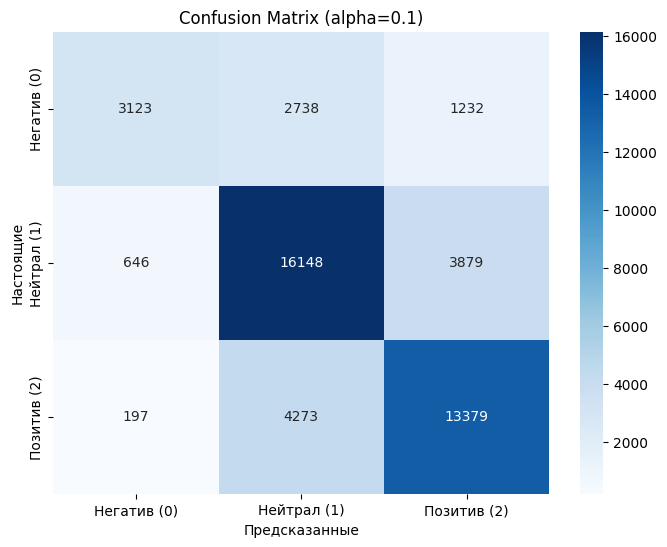

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_nb, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'], 
            yticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'])
plt.title(f'Confusion Matrix (alpha={alpha})')
plt.xlabel('Предсказанные')
plt.ylabel('Настоящие')
plt.show()

In [11]:
print(train_df['label'].value_counts())

label
1    20673
2    17849
0     7093
Name: count, dtype: int64


Точность на тренировочных (LogisticRegression): 0.744
Размер матрицы X_train: (45615, 10000)


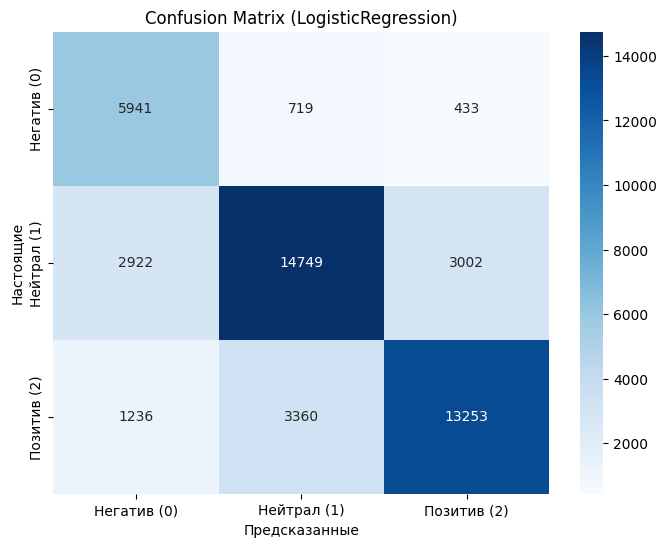

In [15]:
#другая модель, логистическая регрессия

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train_nb)

y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train_nb, y_pred)
print(f"Точность на тренировочных (LogisticRegression): {accuracy:.3f}")
print(f"Размер матрицы X_train: {X_train.shape}")

cm = confusion_matrix(y_train_nb, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'], 
            yticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'])
plt.title('Confusion Matrix (LogisticRegression)')
plt.xlabel('Предсказанные')
plt.ylabel('Настоящие')
plt.show()

label
0    7000
2    7000
1    7000
Name: count, dtype: int64
Точность на тренировочных (сбалансированные данные, alpha=0.1): 0.744
Размер матрицы X_train: (21000, 10000)


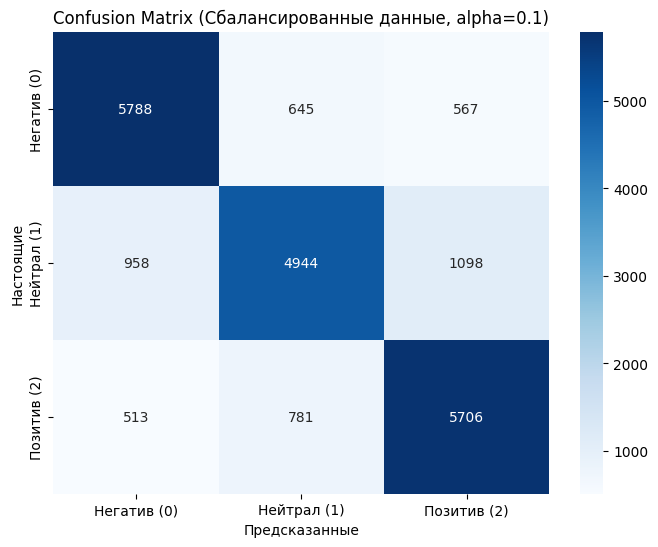

In [17]:
import pandas as pd

# Это с алгоритмом наивный байес. Балансируем классы: берём по 7000 твитов
n_samples = 7000
train_df_balanced = pd.concat([
    train_df[train_df['label'] == 0].sample(n_samples, random_state=42),
    train_df[train_df['label'] == 1].sample(n_samples, random_state=42),
    train_df[train_df['label'] == 2].sample(n_samples, random_state=42)
])
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем баланс
print(train_df_balanced['label'].value_counts())

# Векторизация
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train = vectorizer.fit_transform(train_df_balanced['clean_text'])
y_train = train_df_balanced['label']

# Обучение с MultinomialNB (alpha=0.1)
model_nb = MultinomialNB(alpha=0.1)
model_nb.fit(X_train, y_train)

# Проверка
y_pred_nb = model_nb.predict(X_train)
accuracy_nb = accuracy_score(y_train, y_pred_nb)
print(f"Точность на тренировочных (сбалансированные данные, alpha=0.1): {accuracy:.3f}")
print(f"Размер матрицы X_train: {X_train.shape}")

# Confusion matrix
cm = confusion_matrix(y_train, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'], 
            yticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'])
plt.title('Confusion Matrix (Сбалансированные данные, alpha=0.1)')
plt.xlabel('Предсказанные')
plt.ylabel('Настоящие')
plt.show()

Точность на тренировочных (LogisticRegression, сбалансированные): 0.792
Размер матрицы X_train: (21000, 10000)


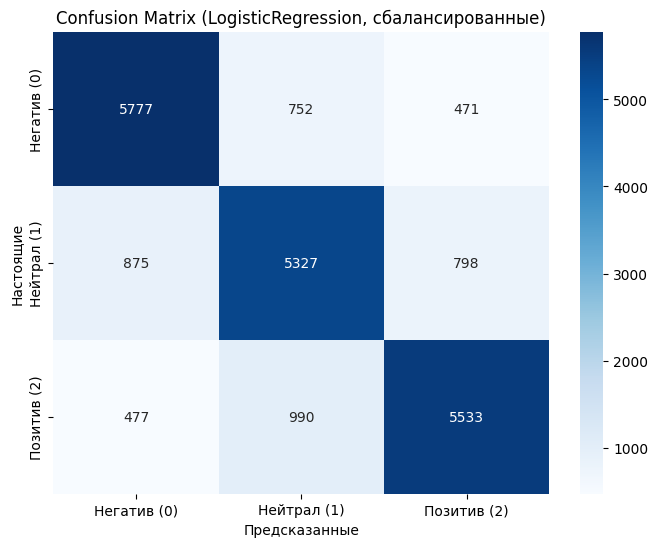

In [18]:
#это с алгоритмом логистическая регрессия
model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Точность на тренировочных (LogisticRegression, сбалансированные): {accuracy:.3f}")
print(f"Размер матрицы X_train: {X_train.shape}")

cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'], 
            yticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'])
plt.title('Confusion Matrix (LogisticRegression, сбалансированные)')
plt.xlabel('Предсказанные')
plt.ylabel('Настоящие')
plt.show()

In [19]:
#выбираем алгоритм логистическая регрессия, т.к. он дал наибольшую точность на обучающих данных и проверяем точность на тестовых данных
# Загружаем датасет
test_df = pd.DataFrame(dataset["test"])
print(test_df.head())  # Первые 5 строк


                                                text  label
0  @user @user what do these '1/2 naked pics' hav...      1
1  OH: “I had a blue penis while I was this” [pla...      1
2  @user @user That's coming, but I think the vic...      1
3  I think I may be finally in with the in crowd ...      2
4  @user Wow,first Hugo Chavez and now Fidel Cast...      0


In [20]:
# Применяем к тренировочным данным
test_df['clean_text'] = test_df['text'].apply(clean_text) #создаем столбец для очищенных данных clean_text и записываем в него очищенные данные
#т.е. мы берем столбик text из таблицы train_df и с помощью apply применяем функцию к каждому элементу и если встретился шаблон регулярного выражения из функуции
# то уже в ффункции через регулярное выражение происходит очистка от этого упоминаний, хештегов, ссылок и лишних пробелов
# Смотрим примеры
print("Примеры очищенных твитов:")
for i, row in test_df.head(5).iterrows():
    print(f"Было: {row['text']}")
    print(f"Стало: {row['clean_text']} -> {row['label']}\n")

Примеры очищенных твитов:
Было: @user @user what do these '1/2 naked pics' have to do with anything? They're not even like that.
Стало: what do these '1/2 naked pics' have to do with anything? They're not even like that. -> 1

Было: OH: “I had a blue penis while I was this” [playing with Google Earth VR]
Стало: OH: “I had a blue penis while I was this” [playing with Google Earth VR] -> 1

Было: @user @user That's coming, but I think the victims are going to be Medicaid recipients.
Стало: That's coming, but I think the victims are going to be Medicaid recipients. -> 1

Было: I think I may be finally in with the in crowd #mannequinchallenge  #grads2014 @user
Стало: I think I may be finally in with the in crowd -> 2

Было: @user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.
Стало: Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes. -

In [21]:
print(test_df['label'].value_counts())

label
1    5937
0    3972
2    2375
Name: count, dtype: int64


Точность на тестовых данных (LogisticRegression): 0.542
Размер матрицы X_test: (12284, 10000)


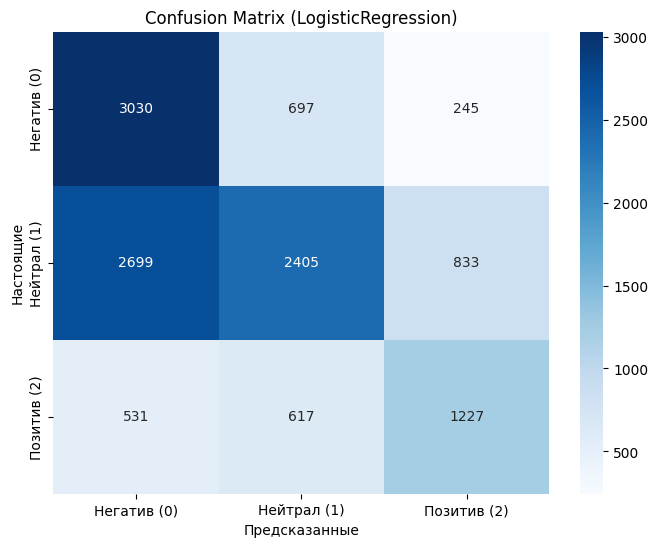

In [22]:
# Векторизация
X_test = vectorizer.transform(test_df['clean_text'])
y_test = test_df['label']

#проверка на тестовых данных
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовых данных (LogisticRegression): {accuracy:.3f}")
print(f"Размер матрицы X_test: {X_test.shape}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'], 
            yticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'])
plt.title('Confusion Matrix (LogisticRegression)')
plt.xlabel('Предсказанные')
plt.ylabel('Настоящие')
plt.show()

Точность на тестовых данных (alpha=0.1): 0.506
Размер матрицы X_test: (12284, 10000)


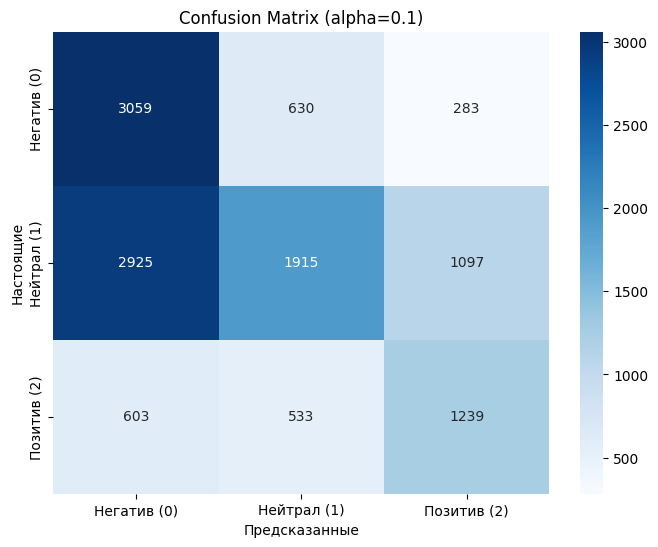

In [25]:
#проверим модель, основанную на алгоритме наивный байес, результат на тестовых данных

# Проверка на тестовых данных
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Точность на тестовых данных (alpha=0.1): {accuracy_nb:.3f}")
print(f"Размер матрицы X_test: {X_test.shape}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'], 
            yticklabels=['Негатив (0)', 'Нейтрал (1)', 'Позитив (2)'])
plt.title('Confusion Matrix (alpha=0.1)')
plt.xlabel('Предсказанные')
plt.ylabel('Настоящие')
plt.show()